# Convolutional Neural Network (CNN)
- Zwei verschiedene Arten von Convolutional Neural Networks (CNNs) werden in diesem Notebook implementiert.
    - CNN mit kausaler Faltung, d.h. die Ausgabe/Vorhersage hängt nur von der Vergangenheit ab.
    - CNN mit normaler Faltung, d.h. die Ausgabe/Vorhersage hängt von der Zukunft und der Vergangenheit ab.

- Es besteht die Möglichkeit, die Audio-Daten in Mel-Spektrogramme oder in MFCCs umzuwandeln.

Bei der Erstellung des Codes wurde sich an den folgenden Quellen orientiert:
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://www.tensorflow.org/tutorials/images/cnn
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy

# 1. Schritt: Audio-Dateien laden und in Spektrogramme umwandeln

In [16]:
import sys

import numpy as np

sys.path.append("/Users/paula/Documents/thm/pki/code")

from convert import get_converted_coswara_audio_files
from convert import get_converted_virufy_audio_files
from convert import get_valid_coswara_filenames

labels_dict = {0: "neg", 1: "pos"}

labels, mels = [], []

# Audio-Dateien laden und in Mel-Spektrogramme konvertieren
p_filenames, n_filenames = get_valid_coswara_filenames()

p_coswara_mels, p_coswara_labels = get_converted_coswara_audio_files(
    p_filenames, is_positive=True, convert_to_mel=True
)
n_coswara_mels, n_coswara_labels = get_converted_coswara_audio_files(
    n_filenames, is_positive=False, convert_to_mel=True
)

p_virufy_mels, p_virufy_labels = get_converted_virufy_audio_files(
    is_positive=True, convert_to_mel=True
)
n_virufy_mels, n_virufy_labels = get_converted_virufy_audio_files(
    is_positive=False, convert_to_mel=True
)


mels = np.concatenate(
    (p_coswara_mels, n_coswara_mels, p_virufy_mels, n_virufy_mels)
)
labels = np.concatenate(
    (p_coswara_labels, n_coswara_labels, p_virufy_labels, n_virufy_labels)
)

/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/Users/paula/opt/anaconda3/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=len(labels_dict))

# Train-Test-Split durchführen
mel_train, mel_test, labels_train, labels_test = train_test_split(
    mels, labels, test_size=0.2, random_state=42
)
mel_train = mels
labels_train = labels

# print(
#     f"""mel_train.shape: {mel_train.shape},
#     labels_train.shape: {labels_train.shape}"""
# )
# print(
#     f"""mel_test.shape: {mel_test.shape},
#     labels_test.shape: {labels_test.shape}"""
# )

# 3. Schritt: CNN-Modelle erstellen

In [18]:
# Konfiguration des Trainingsprozesses
BATCH_SIZE = 64
EPOCHS = 20
ACTIVATION_1 = "relu"
ACTIVATION_2 = "softmax"
METRIC = "accuracy"
LOSS = "categorical_crossentropy"
OPTIMIZER = "adam"

In [19]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential


def build_cnn(*, include_future: bool) -> Sequential:
    """Erstellt ein CNN-Modell, das auf den Mel-Spektrogrammen trainiert wird.

    :param include_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: CNN-Modell (TensorFlow Sequential Model)
    """
    # CNN-Modell wird definiert
    model = Sequential()

    # Eingabeform: (128, 128, 1)
    input_shape = mel_train[0].shape

    padding_value = "valid"
    if not include_future:
        padding_value = "causal"

    # Convolutional-Schicht
    # 32 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(
        Conv1D(
            32,
            kernel_size=3,
            activation=ACTIVATION_1,
            input_shape=(input_shape),
            padding=padding_value,
        )
    )

    # MaxPooling-Schicht
    # Reduziert die Größe der Ausgabe, indem es die höchsten Werte
    # aus 2 Blöcken auswählt
    model.add(MaxPooling1D(pool_size=2))

    # Convolutional-Schicht
    # 64 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(
        Conv1D(
            64, kernel_size=3, activation=ACTIVATION_1, padding=padding_value
        )
    )

    # Wandelt die mehrdimensionale Ausgabe in einen Vektor um
    model.add(Flatten())

    # Dense-Schicht
    # 64 Neuronen, Aktivierungsfunktion ReLU (Führt Klassifizierungslogik durch)
    model.add(Dense(64, activation=ACTIVATION_1))

    # Dropout-Schicht
    # Ausgabeschicht mit einer Neuronanzahl, die der
    # Anzahl der Klassen (2 für positiv/negativ) entspricht.
    model.add(Dense(len(labels_dict), activation=ACTIVATION_2))
    # model.summary()
    return model

# 3.1. Schritt: CNN mit kausaler Faltung

In [20]:
causal_model = build_cnn(include_future=False)

# 3.2. Schritt: CNN mit normaler Faltung

In [21]:
model = build_cnn(include_future=True)

# 4. Modell kompilieren

In [22]:
# Modelle werden für das Training vorbereitet
# Optimierungsalgorithmus: Adam (Optimierungsalgorithmus) (Wie werden die
# Gewichte angepasst)
# Verlustfunktion: Categorical Crossentropy (Wie werden die Fehler berechnet)
# Metrik: Genauigkeit (Welche Metrik wird zur Bewertung des Modells verwendet)
causal_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRIC])

#  5 Schritt: W&B Project initialisieren und Modell trainieren

In [23]:
def train_and_wandbLog(
    model, mel_train, labels_train, mel_test, labels_test, *, with_future: bool
):
    """Trainiert das Modell und loggt die Metriken in Weights & Biases.

    :param model: Modell, das trainiert werden soll
    :param mel_train: Trainingsdaten (Mel-Spektrogramme oder MFCCs)
    :param labels_train: Trainingsdaten (Labels)
    :param mel_test: Testdaten (Mel-Spektrogramme oder MFCCs)
    :param labels_test: Testdaten (Labels)
    :param with_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: History-Objekt des Trainingsprozesses
    """
    import wandb

    wandb.init(
        project="cnn_covid_audio_classification",
        config={
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "architecture": "CNN",
            "dataset": "coswara + virufy",
            "activation_1": ACTIVATION_1,
            "activation_2": ACTIVATION_2,
            "metric": METRIC,
            "loss": LOSS,
            "optimizer": OPTIMIZER,
        },
    )

    # WandB Run Name setzen
    FUTURE = "FUTURE" if with_future else "NO_FUTURE"
    wandb.run.name = f"{FUTURE}_batch_size_{BATCH_SIZE}_epochs_{EPOCHS}_activation_1_{ACTIVATION_1}_activation_2_{ACTIVATION_2}_metric_{METRIC}_loss_{LOSS}_optimizer_{OPTIMIZER}"

    history = model.fit(
        mel_train,
        labels_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(mel_test, labels_test),
        callbacks=[
            wandb.keras.WandbMetricsLogger(log_freq=5),
            wandb.keras.WandbModelCheckpoint("models"),
        ],
    )

    wandb.finish()
    return history

In [24]:
# Training des Modells
history = train_and_wandbLog(
    model, mel_train, labels_train, mel_test, labels_test, with_future=True
)
causal_history = train_and_wandbLog(
    causal_model,
    mel_train,
    labels_train,
    mel_test,
    labels_test,
    with_future=False,
)

Epoch 1/20
59/71 [=======================>......] - ETA: 0s - loss: 2.5858 - accuracy: 0.6504

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 2s 17ms/step - loss: 2.2559 - accuracy: 0.6584 - val_loss: 0.6292 - val_accuracy: 0.6759
Epoch 2/20
67/71 [===========================>..] - ETA: 0s - loss: 0.6068 - accuracy: 0.6996

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 16ms/step - loss: 0.6071 - accuracy: 0.6968 - val_loss: 0.5974 - val_accuracy: 0.6759
Epoch 3/20
63/71 [=========================>....] - ETA: 0s - loss: 0.5731 - accuracy: 0.7073

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 19ms/step - loss: 0.5756 - accuracy: 0.7074 - val_loss: 0.5844 - val_accuracy: 0.7233
Epoch 4/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5828 - accuracy: 0.7000

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5792 - accuracy: 0.7032 - val_loss: 0.6111 - val_accuracy: 0.6792
Epoch 5/20
62/71 [=========================>....] - ETA: 0s - loss: 0.5665 - accuracy: 0.7188

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5619 - accuracy: 0.7235 - val_loss: 0.5745 - val_accuracy: 0.6913
Epoch 6/20
68/71 [===========================>..] - ETA: 0s - loss: 0.5628 - accuracy: 0.7213

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5632 - accuracy: 0.7211 - val_loss: 0.5654 - val_accuracy: 0.7178
Epoch 7/20
64/71 [==========================>...] - ETA: 0s - loss: 0.5567 - accuracy: 0.7249

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5582 - accuracy: 0.7235 - val_loss: 0.5721 - val_accuracy: 0.7133
Epoch 8/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5499 - accuracy: 0.7320

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5485 - accuracy: 0.7325 - val_loss: 0.5565 - val_accuracy: 0.7189
Epoch 9/20
64/71 [==========================>...] - ETA: 0s - loss: 0.5454 - accuracy: 0.7388

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5485 - accuracy: 0.7350 - val_loss: 0.5566 - val_accuracy: 0.7255
Epoch 10/20
68/71 [===========================>..] - ETA: 0s - loss: 0.5399 - accuracy: 0.7429

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5422 - accuracy: 0.7407 - val_loss: 0.5867 - val_accuracy: 0.7023
Epoch 11/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5480 - accuracy: 0.7332

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5492 - accuracy: 0.7316 - val_loss: 0.5513 - val_accuracy: 0.7233
Epoch 12/20
68/71 [===========================>..] - ETA: 0s - loss: 0.5392 - accuracy: 0.7369

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5394 - accuracy: 0.7365 - val_loss: 0.5438 - val_accuracy: 0.7189
Epoch 13/20
69/71 [============================>.] - ETA: 0s - loss: 0.5337 - accuracy: 0.7371

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 17ms/step - loss: 0.5340 - accuracy: 0.7358 - val_loss: 0.5515 - val_accuracy: 0.7111
Epoch 14/20
69/71 [============================>.] - ETA: 0s - loss: 0.5385 - accuracy: 0.7351

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5379 - accuracy: 0.7356 - val_loss: 0.5448 - val_accuracy: 0.7299
Epoch 15/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5293 - accuracy: 0.7434

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.1s


71/71 [==============================] - 1s 15ms/step - loss: 0.5299 - accuracy: 0.7429 - val_loss: 0.5426 - val_accuracy: 0.7166
Epoch 16/20
64/71 [==========================>...] - ETA: 0s - loss: 0.5261 - accuracy: 0.7493

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5268 - accuracy: 0.7471 - val_loss: 0.5278 - val_accuracy: 0.7288
Epoch 17/20
58/71 [=======================>......] - ETA: 0s - loss: 0.5231 - accuracy: 0.7384

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5273 - accuracy: 0.7376 - val_loss: 0.5340 - val_accuracy: 0.7255
Epoch 18/20
70/71 [============================>.] - ETA: 0s - loss: 0.5227 - accuracy: 0.7446

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5225 - accuracy: 0.7451 - val_loss: 0.5377 - val_accuracy: 0.7089
Epoch 19/20
60/71 [========================>.....] - ETA: 0s - loss: 0.5089 - accuracy: 0.7576

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5128 - accuracy: 0.7530 - val_loss: 0.5154 - val_accuracy: 0.7321
Epoch 20/20
69/71 [============================>.] - ETA: 0s - loss: 0.5105 - accuracy: 0.7477

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 13ms/step - loss: 0.5096 - accuracy: 0.7475 - val_loss: 0.5162 - val_accuracy: 0.7409


batch/accuracy,▁▃▄▄▄▆▆▆▅▅▆▆▆▆▆▆█▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▅▄▆▆▆▆▇▇▆▇▇▇▇█▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▆▁▃▆▅▆▆▄▆▆▅▇▅▇▆▅▇█
epoch/val_loss,█▆▅▇▅▄▄▄▄▅▃▃▃▃▃▂▂▂▁▁
batch/accuracy,0.74752


Epoch 1/20
63/71 [=========================>....] - ETA: 0s - loss: 1.6424 - accuracy: 0.6761

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 16ms/step - loss: 1.5279 - accuracy: 0.6785 - val_loss: 0.5970 - val_accuracy: 0.6759
Epoch 2/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5886 - accuracy: 0.6993

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 18ms/step - loss: 0.5876 - accuracy: 0.7010 - val_loss: 0.5909 - val_accuracy: 0.6781
Epoch 3/20
60/71 [========================>.....] - ETA: 0s - loss: 0.5698 - accuracy: 0.7154

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5729 - accuracy: 0.7127 - val_loss: 0.5717 - val_accuracy: 0.7023
Epoch 4/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5599 - accuracy: 0.7133

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5579 - accuracy: 0.7136 - val_loss: 0.5957 - val_accuracy: 0.6869
Epoch 5/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5574 - accuracy: 0.7249

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5559 - accuracy: 0.7248 - val_loss: 0.5631 - val_accuracy: 0.7056
Epoch 6/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5543 - accuracy: 0.7298

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5533 - accuracy: 0.7301 - val_loss: 0.5635 - val_accuracy: 0.7056
Epoch 7/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5507 - accuracy: 0.7188

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 13ms/step - loss: 0.5494 - accuracy: 0.7213 - val_loss: 0.5585 - val_accuracy: 0.7200
Epoch 8/20
60/71 [========================>.....] - ETA: 0s - loss: 0.5488 - accuracy: 0.7305

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5427 - accuracy: 0.7374 - val_loss: 0.5481 - val_accuracy: 0.7255
Epoch 9/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5350 - accuracy: 0.7425

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5370 - accuracy: 0.7420 - val_loss: 0.5429 - val_accuracy: 0.7200
Epoch 10/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5300 - accuracy: 0.7445

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 13ms/step - loss: 0.5318 - accuracy: 0.7429 - val_loss: 0.5465 - val_accuracy: 0.7222
Epoch 11/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5327 - accuracy: 0.7411

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5334 - accuracy: 0.7411 - val_loss: 0.5420 - val_accuracy: 0.7321
Epoch 12/20
65/71 [==========================>...] - ETA: 0s - loss: 0.5235 - accuracy: 0.7437

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 17ms/step - loss: 0.5273 - accuracy: 0.7427 - val_loss: 0.5410 - val_accuracy: 0.7233
Epoch 13/20
67/71 [===========================>..] - ETA: 0s - loss: 0.5229 - accuracy: 0.7449

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5219 - accuracy: 0.7466 - val_loss: 0.5295 - val_accuracy: 0.7155
Epoch 14/20
66/71 [==========================>...] - ETA: 0s - loss: 0.5202 - accuracy: 0.7474

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5217 - accuracy: 0.7460 - val_loss: 0.5252 - val_accuracy: 0.7332
Epoch 15/20
61/71 [========================>.....] - ETA: 0s - loss: 0.5142 - accuracy: 0.7464

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.5172 - accuracy: 0.7475 - val_loss: 0.5120 - val_accuracy: 0.7497
Epoch 16/20
62/71 [=========================>....] - ETA: 0s - loss: 0.5058 - accuracy: 0.7515

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 14ms/step - loss: 0.5097 - accuracy: 0.7495 - val_loss: 0.5299 - val_accuracy: 0.7288
Epoch 17/20
68/71 [===========================>..] - ETA: 0s - loss: 0.5076 - accuracy: 0.7528

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 16ms/step - loss: 0.5065 - accuracy: 0.7528 - val_loss: 0.5214 - val_accuracy: 0.7155
Epoch 18/20
69/71 [============================>.] - ETA: 0s - loss: 0.5032 - accuracy: 0.7559

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 16ms/step - loss: 0.5036 - accuracy: 0.7552 - val_loss: 0.5050 - val_accuracy: 0.7343
Epoch 19/20
60/71 [========================>.....] - ETA: 0s - loss: 0.4994 - accuracy: 0.7573

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 16ms/step - loss: 0.4947 - accuracy: 0.7574 - val_loss: 0.4993 - val_accuracy: 0.7530
Epoch 20/20
67/71 [===========================>..] - ETA: 0s - loss: 0.4856 - accuracy: 0.7652

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.0s


71/71 [==============================] - 1s 15ms/step - loss: 0.4874 - accuracy: 0.7636 - val_loss: 0.5018 - val_accuracy: 0.7530


batch/accuracy,▃▄▄▅▆▅▆▆▆▆▆▆▆▇▇▇▇▃██▇▇█▇▇█▇▇▁█▇▅██▇██▁▇█
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▃▂▄▄▅▆▅▅▆▅▅▆█▆▅▆██
epoch/val_loss,██▆█▆▆▅▄▄▄▄▄▃▃▂▃▃▁▁▁
batch/accuracy,0.76362


# 6. Evaluation

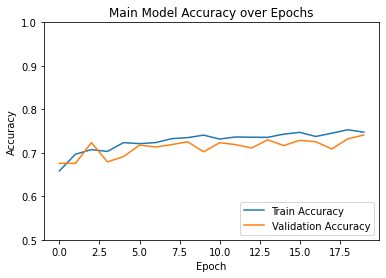

29/29 - 0s - loss: 0.5162 - accuracy: 0.7409 - 49ms/epoch - 2ms/step
Main Model Test Accuracy: 0.7409
Main Model Test Loss: 0.5162


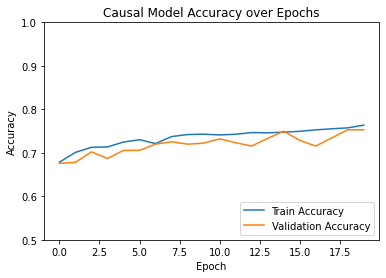

29/29 - 0s - loss: 0.5018 - accuracy: 0.7530 - 49ms/epoch - 2ms/step
Causal Model Test Accuracy: 0.7530
Causal Model Test Loss: 0.5018


In [27]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential,
    history: Sequential,
    mel_test: dict,
    labels_test: dict,
    model_name: str = "Model",
) -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mel_test: Testdaten (Mel-Spektrogramme)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mel_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell
plot_accuracy_and_evaluate(
    model, history, mel_test, labels_test, model_name="Main Model"
)

# Beispielaufruf für das Causal Modell
plot_accuracy_and_evaluate(
    causal_model,
    causal_history,
    mel_test,
    labels_test,
    model_name="Causal Model",
)